# Postprocessing demo
This notebook demonstrates some of the postprocessing techniques described by Cormode et al.


## Example: random points
In this example, we first generate some points at random according to a Poisson point process. We build a quadtree over these points, privatize it (exactly as in `demo.ipynb`), and then we apply postprocessing techniques to try and improve results.

In [148]:
from cormode.classical import QuadTreeNode
from shapely import geometry
from cormode import gen
from matplotlib import pyplot as plt

lambda_poisson = 400

points = gen.generate_points_no_cluster(geometry.box(0,0,1,1), lambda_poisson)
points_x, points_y = ([x for (x, _) in points], [y for (_, y) in points])


# height is the maximum number of edges from root to leaf.
# since each level subdivides space into quadrants, level i represents a 2^i by 2^i grid.
tree = QuadTreeNode(height = 2) 

# inserting a point into the quadtree increments the count at each node containing the point.
for point in points:
    tree.insert_point(point)

### Visualize quadtree

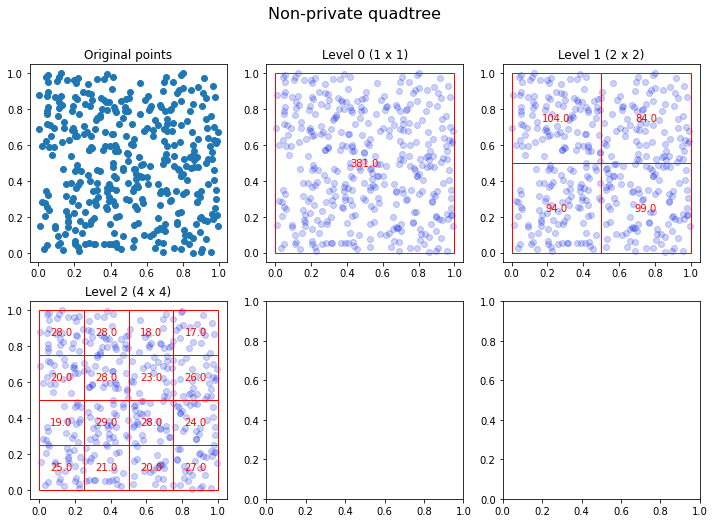

In [149]:
fig, axes = plt.subplots(1 + ((tree.height + 1) // 3), 3, figsize=(12,8))
fig.suptitle("Non-private quadtree", fontsize=16)

axes[0][0].set_title("Original points")
axes[0][0].scatter(points_x, points_y)

# draw example using level-order traversal
nodes = [tree]
for level in range(tree.height + 1):
    next_nodes = []
    ax = axes[(level + 1) // 3][(level + 1) % 3]
    ax.set_title(f"Level {level} ({2**level} x {2**level})")

    ax.scatter(points_x, points_y, color=(0.0, 0.1, 0.9, 0.2))

    for node in nodes:
        rect = plt.Rectangle((node.rect.xmin, node.rect.ymin), (node.rect.xmax - node.rect.xmin), (node.rect.ymax - node.rect.ymin), facecolor=(0,0,0,0), edgecolor="red")
        ax.add_patch(rect)

        center_x = (node.rect.xmin + node.rect.xmax) / 2
        center_y = (node.rect.ymin + node.rect.ymax) / 2

        if level < 4:
            ax.text(center_x, center_y, str(node.count), horizontalalignment="center", verticalalignment="center", color="red")

        if not node.is_leaf:
            next_nodes += node.children
    
    nodes = next_nodes

### Generate private quadtree

In [150]:
from cormode import private

# overall privacy parameter
EPSILON = 1.0
# uses geometric budgeting strategy from Cormode et al.
private_tree = private.make_private_quadtree(tree, EPSILON, budget_strategy=private.BudgetStrategy.GEOMETRIC)

### Visualize private quadtree

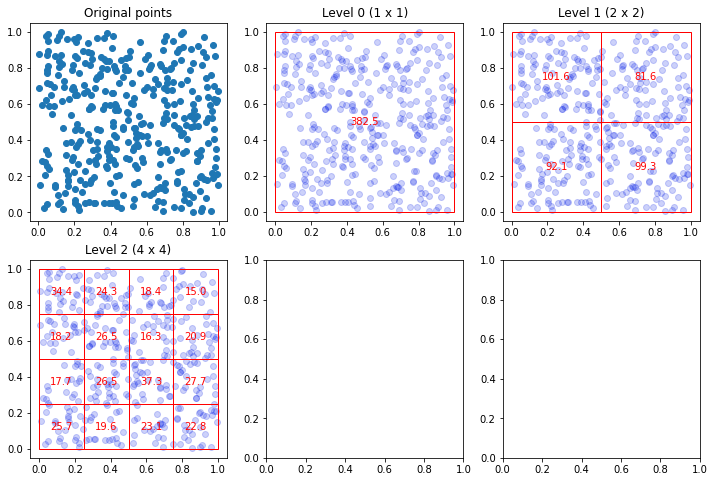

In [151]:
fig, axes = plt.subplots(1 + ((tree.height + 1) // 3), 3, figsize=(12,8))

axes[0][0].set_title("Original points")
axes[0][0].scatter(points_x, points_y)

# draw example using level-order traversal
nodes = [private_tree]
for level in range(private_tree.height + 1):
    next_nodes = []
    ax = axes[(level + 1) // 3][(level + 1) % 3]
    ax.set_title(f"Level {level} ({2**level} x {2**level})")

    ax.scatter(points_x, points_y, color=(0.0, 0.1, 0.9, 0.2))

    for node in nodes:
        rect = plt.Rectangle((node.rect.xmin, node.rect.ymin), (node.rect.xmax - node.rect.xmin), (node.rect.ymax - node.rect.ymin), facecolor=(0,0,0,0), edgecolor="red")
        ax.add_patch(rect)

        center_x = (node.rect.xmin + node.rect.xmax) / 2
        center_y = (node.rect.ymin + node.rect.ymax) / 2

        if level < 4:
            ax.text(center_x, center_y, f"{node.count:.1f}", horizontalalignment="center", verticalalignment="center", color="red")

        if not node.is_leaf:
            next_nodes += node.children
    
    nodes = next_nodes

### Apply postprocessing
We can improve query accuracy against the private quadtree by performing a postprocessing step.

The postprocessing step takes the privatized tree as its sole input, so it does not affect the guarantee of epsilon-DP.

In [152]:
from cormode import postprocessing

ols_tree = postprocessing.build_ols_tree(private_tree)

### Visualize OLS tree

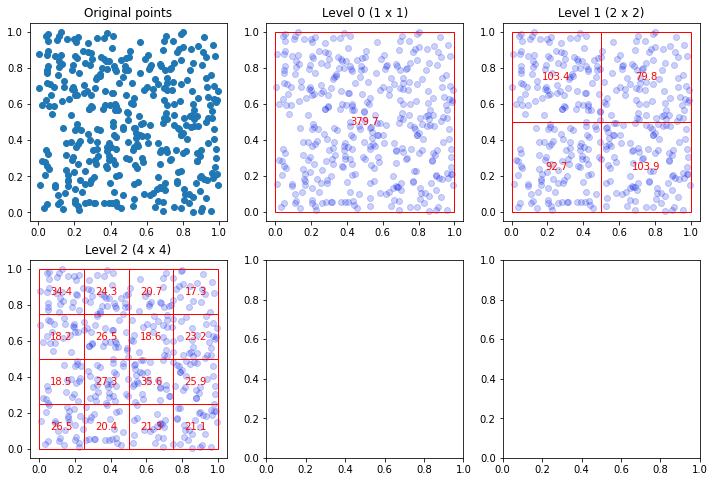

In [153]:
fig, axes = plt.subplots(1 + ((tree.height + 1) // 3), 3, figsize=(12,8))

axes[0][0].set_title("Original points")
axes[0][0].scatter(points_x, points_y)

# draw example using level-order traversal
nodes = [ols_tree]
for level in range(ols_tree.height + 1):
    next_nodes = []
    ax = axes[(level + 1) // 3][(level + 1) % 3]
    ax.set_title(f"Level {level} ({2**level} x {2**level})")

    ax.scatter(points_x, points_y, color=(0.0, 0.1, 0.9, 0.2))

    for node in nodes:
        rect = plt.Rectangle((node.rect.xmin, node.rect.ymin), (node.rect.xmax - node.rect.xmin), (node.rect.ymax - node.rect.ymin), facecolor=(0,0,0,0), edgecolor="red")
        ax.add_patch(rect)

        center_x = (node.rect.xmin + node.rect.xmax) / 2
        center_y = (node.rect.ymin + node.rect.ymax) / 2

        if level < 4:
            ax.text(center_x, center_y, f"{node.count:.1f}", horizontalalignment="center", verticalalignment="center", color="red")

        if not node.is_leaf:
            next_nodes += node.children
    
    nodes = next_nodes

# Spatial cluster detection
Now that we have mechanisms for privately indexing points in space and executing counting queries on arbitrary regions, we can try applying spatial cluster detection methods. We start by generating data.

## Generate data
We generate data according to a Poisson point process, assuming the presence of a single cluster with an elevated Poisson parameter.

In [154]:
import numpy as np
from matplotlib.patches import Patch

population = 400_000 # a city of 400,000 people
background_incidence_rate = 0.005 # 0.5% incidence outside of cluster
cluster_incidence_rate = 0.01 # 1% incidence inside cluster

lambda_background = background_incidence_rate * population
lambda_cluster = cluster_incidence_rate * population # no need to scale by cluster area, this is handled by cormode.gen module

cluster_center = (np.random.uniform(0,1), np.random.uniform(0,1))
cluster_radius = np.random.uniform(0.1, 0.25)
cluster_region = geometry.Point(*cluster_center).buffer(cluster_radius)

points = gen.generate_points_single_cluster(
    geometry.box(0,0,1,1),
    lambda_background,
    cluster_region,
    lambda_cluster
)

In [155]:
tree = QuadTreeNode(height=3)

for point in points:
    tree.insert_point(point)

EPSILON = 1.0
private_tree = private.make_private_quadtree(tree, EPSILON, budget_strategy=private.BudgetStrategy.GEOMETRIC)
ols_tree = postprocessing.build_ols_tree(private_tree)

## Finding maximally anomalous region
Now, we can sweep a circle over the map and calculate the scan statistic at each point to try and find the maximally anomalous region.

Non-private IoU: 0.46478536724749325
Private IoU: 0.46478536724749325


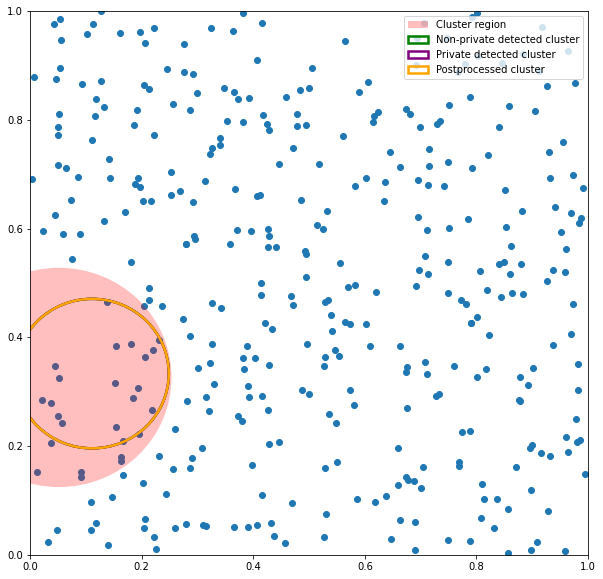

In [156]:
import cluster
import util

nonprivate_scan_statistic, nonprivate_region = cluster.find_max_scan_statistic_sweep(tree, population)
private_scan_statistic, private_region = cluster.find_max_scan_statistic_sweep(private_tree, population)
ols_scan_statistic, ols_region = cluster.find_max_scan_statistic_sweep(ols_tree, population)

plt.figure(figsize=(10,10))
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(points_x, points_y)
plt.gca().add_patch(plt.Circle(cluster_center, cluster_radius, facecolor=(1,0,0,.25)))
plt.gca().add_patch(plt.Circle(*nonprivate_region,facecolor=(0,0,0,0), edgecolor="green", linewidth=2.5))
plt.gca().add_patch(plt.Circle(*private_region,facecolor=(0,0,0,0), edgecolor="purple", linewidth=2.5))
plt.gca().add_patch(plt.Circle(*ols_region,facecolor=(0,0,0,0), edgecolor="orange", linewidth=2.5))

# computer IoU for each region
nonprivate_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*nonprivate_region))
private_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*private_region))
ols_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*ols_region))


print("Non-private IoU:", nonprivate_iou)
print("Private IoU:", private_iou)

legend = [
    Patch(facecolor=(1,0,0,0.25), label="Cluster region"),
    Patch(facecolor=(0,0,0,0), edgecolor="green", linewidth=2.5, label="Non-private detected cluster"),
    Patch(facecolor=(0,0,0,0), edgecolor="purple", linewidth=2.5, label="Private detected cluster"),
    Patch(facecolor=(0,0,0,0), edgecolor="orange", linewidth=2.5, label="Postprocessed cluster"),
]
plt.gca().legend(handles=legend, loc="upper right")